In [129]:
#import libraries
import cmath
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.environ import *

#load data
xls = pd.ExcelFile('data\case68.xlsx')
# xls = pd.ExcelFile('data\case39.xlsx')
branch = pd.read_excel(xls, 'branch')
gen = pd.read_excel(xls, 'gen')
bus = pd.read_excel(xls, 'bus')
cost = pd.read_excel(xls, 'cost')

#Y matrix
base = 1
bus_len = bus.shape[0]
gen_len = len(gen['bus'].ravel())

Ybus = np.matrix(np.zeros([bus_len,bus_len]),dtype=complex)
shunt = np.zeros(bus_len, dtype=complex)
x = [pd.DataFrame() for i in range(bus_len)]
for i in range(bus_len+1):  
    x[i-1] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i-1]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i-1]['r']).iloc[j][0],pd.DataFrame(x[i-1]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i-1]['r']).iloc[j][0],pd.DataFrame(x[i-1]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i-1]['b'])/2)

for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)

# declare variables
Pd = np.zeros(bus_len)
Qd = np.zeros(bus_len)
Vmax = np.zeros(bus_len)
Vmin = np.zeros(bus_len)
Pmax = np.zeros(bus_len)
Pmin = np.zeros(bus_len)
Qmax = np.zeros(bus_len)
Qmin = np.zeros(bus_len)
cost_lin = np.zeros(bus_len)
cost_quad = np.zeros(bus_len)

for i in range(bus_len):
    Pd[i] = bus['Pd'][i]/base
    Qd[i] = bus['Qd'][i]/base
    Vmax[i] = bus['Vmax'][i]
    Vmin[i] = bus['Vmin'][i]

for i in range(gen_len):
    k = i
    i = gen['bus'].ravel()[i]
    Pmax[i-1] = gen.loc[gen['bus'] == i]['Pmax'].ravel()[0]/base
    Pmin[i-1] = gen.loc[gen['bus'] == i]['Pmin'].ravel()[0]/base
    Qmax[i-1] = gen.loc[gen['bus'] == i]['Qmax'].ravel()[0]/base
    Qmin[i-1] = gen.loc[gen['bus'] == i]['Qmin'].ravel()[0]/base
    cost_lin[i-1] = cost['lin'][k]*base
    cost_quad[i-1] = cost['quad'][k]*base**2
      
#Create a model
model = pyo.ConcreteModel()

model.IDX1 = range(gen_len)
model.IDX2 = range(bus_len)
model.Pg = pyo.Var(model.IDX2)
model.Qg = pyo.Var(model.IDX2)
model.t = pyo.Var(model.IDX2)
model.v = pyo.Var(model.IDX2)
for i in model.IDX2:
    model.Pg[i].fix(0) 
    model.Qg[i].fix(0) 
    
for i in model.IDX1:
    model.Pg[gen['bus'][i]-1].fixed = False
    model.Qg[gen['bus'][i]-1].fixed = False


# declare constraints
model.c = pyo.ConstraintList()

for i in range(bus_len):
    model.c.add(expr = model.Pg[i] <= Pmax[i])
    model.c.add(expr = model.Pg[i] >= Pmin[i])
    model.c.add(expr = model.Qg[i] <= Qmax[i])
    model.c.add(expr = model.Qg[i] >= Qmin[i])
    model.c.add(expr = model.v[i] <= Vmax[i])
    model.c.add(expr = model.v[i] >= Vmin[i])    

#Bus voltage angle initial condition
model.c.add(model.t[0] == 0)


#Nodal equations
for i in range(bus_len):
    model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Pg[i] + Pd[i]== 0)
    model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] + Qd[i]== 0)

#Line flow constraints
for i in range(len(branch)): 
    x = int(branch.loc[i]['fbus'])-1
    y = int(branch.loc[i]['tbus'])-1
    val = (branch.loc[i]['rateA']/base)
    if(val == 0):
        val = 100
    
#    With phasor
    Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
    Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     
    
    Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
    Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     
    
#     if ((x == 67) & (y == 66)):
#         Pxy = 'value'
#     else:
    model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
    model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)

#      
# declare objective
model.cost = pyo.Objective( 
    expr = sum(cost['cons']) + 
    (sum(model.Pg[i]*cost_lin[i] for i in model.IDX2)) + 
    (sum(cost_quad[i]*model.Pg[i]**2 for i in model.IDX2))
) 

# solve
SolverFactory('ipopt').solve(model)#.write()


#Print results
print('Cost = ',model.cost())


# # Debug code
# from pyomo.util.infeasible import log_infeasible_constraints
# SolverFactory('ipopt').solve(model)
# log_infeasible_constraints(model)



Cost =  5451.032338801284


In [89]:
def _make_report_header(maxN):
    """Return the header and format string for reporting coverage."""
    nw = len(str(maxN))
    frac_width = 2*nw + 1  # width of 300/1000
    frac_header = 'Sample'
    frac_format = '{i:' + str(nw) + 'd}/{n:' + str(nw) + 'd}'
    if frac_width < len(frac_header):
        pad = ''.join([' ' for _ in range(len(frac_header) - frac_width)])
        frac_format = pad + frac_format
    elif len(frac_header) < frac_width:
        pad = ''.join([' ' for _ in range(frac_width - len(frac_header))])
        frac_header = pad + frac_header
    hdr = frac_header + "   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible"
    fmt = frac_format + "    {cov:6.2f}%   {min:6.4f}   {med:6.4f}   {max:6.4f}   {ela:9.2f}     {rem:9.2f}   {inf:10d}"
    return hdr, fmt

def _maxgap(points, fva=None):
    # points has rows = samples, columns = variables

    # make a copy because we're going to sort the columns
    points = points.copy()
    if fva is not None:
        points = np.vstack((fva.minimum, points, fva.maximum))
    points.sort(0)

    gaps = points[1:,:] - points[0:-1,:]
    width = gaps.max(0)
    loc = gaps.argmax(0)
    left = np.zeros(width.size)
    for i in range(width.size):
        left[i] = points[loc[i],i]
    relative = width / (points[-1,:] - points[0,:])
    target = left + width/2

    return relative, target, width

In [122]:
for i in range(bus_len+1):  
    x[i-1] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i-1]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i-1]['r']).iloc[j][0],pd.DataFrame(x[i-1]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i-1]['r']).iloc[j][0],pd.DataFrame(x[i-1]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i-1]['b'])/2)

for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)

In [125]:
#load data
import numpy as np
import pandas as pd
xls = pd.ExcelFile('data\case68.xlsx')
branch = pd.read_excel(xls, 'branch')
gen = pd.read_excel(xls, 'gen')
bus = pd.read_excel(xls, 'bus')
cost = pd.read_excel(xls, 'cost')
base = 100  

#Y matrix
base = 1
bus_len = bus.shape[0]
gen_len = len(gen['bus'].ravel())

Ybus = np.matrix(np.zeros([bus_len,bus_len]),dtype=complex)
shunt = np.zeros(bus_len, dtype=complex)
x = [pd.DataFrame() for i in range(bus_len)]
for i in range(bus_len+1):  
    x[i-1] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i-1]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i-1]['r']).iloc[j][0],pd.DataFrame(x[i-1]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i-1]['r']).iloc[j][0],pd.DataFrame(x[i-1]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i-1]['b'])/2)

for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)

# declare variables
Pd = np.zeros(bus_len)
Qd = np.zeros(bus_len)
Vmax = np.zeros(bus_len)
Vmin = np.zeros(bus_len)
Pmax = np.zeros(bus_len)
Pmin = np.zeros(bus_len)
Qmax = np.zeros(bus_len)
Qmin = np.zeros(bus_len)
cost_lin = np.zeros(bus_len)
cost_quad = np.zeros(bus_len)

for i in range(bus_len):
    Pd[i] = bus['Pd'][i]/base
    Qd[i] = bus['Qd'][i]/base
    Vmax[i] = bus['Vmax'][i]
    Vmin[i] = bus['Vmin'][i]

for i in range(gen_len):
    k = i
    i = gen['bus'].ravel()[i]
    Pmax[i-1] = gen.loc[gen['bus'] == i]['Pmax'].ravel()[0]/base
    Pmin[i-1] = gen.loc[gen['bus'] == i]['Pmin'].ravel()[0]/base
    Qmax[i-1] = gen.loc[gen['bus'] == i]['Qmax'].ravel()[0]/base
    Qmin[i-1] = gen.loc[gen['bus'] == i]['Qmin'].ravel()[0]/base
    cost_lin[i-1] = cost['lin'][k]*base
    cost_quad[i-1] = cost['quad'][k]*base**2

p = pd.DataFrame([gen['Pmin'],gen['Pmax']]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P%s' % (i+1) for i in range(gen_len)]
p = p.T/base

q = pd.DataFrame([gen['Qmin'],gen['Qmax']]).T
q.columns = ['minimum', 'maximum']
q = q.T
q.columns = ['Q%s' % (i+1) for i in range(gen_len)]
q = q.T/base

v = pd.DataFrame([bus['Vmin'],bus['Vmax']]).T
v.columns = ['minimum', 'maximum']
v = v.T
v.columns = ['V%s' % (i+1) for i in range(bus_len)]
v = v.T

# l_p = pd.DataFrame([(Pd - 0.5*Pd),(Pd + 0.5*Pd)]).T
# l_p.columns = ['minimum','maximum']
# l_p = l_p.T
# l_p.columns = ['Pd_%s' % (i+1) for i in range(bus_len)]
# l_p = l_p.T

# l_q = pd.DataFrame([(Qd - 0.5*Qd), (Qd + 0.5*Qd)]).T
# l_q.columns = ['minimum','maximum']
# l_q = l_q.T
# l_q.columns = ['Qd_%s' % (i+1) for i in range(bus_len)]
# l_q = l_q.T


fva = pd.concat([p,q])

In [130]:
# Case 1: Static Load
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len))

    model.vars = Var(range(len(fva)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(len(fva)):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
                holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 +  Pd[i] == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 +  Qd[i] == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 0)

    solution = SolverFactory('ipopt').solve(model)

    # Line flow data
    Pxyp = np.zeros(len(branch))
    Pyxp = np.zeros(len(branch))
    Qxyp = np.zeros(len(branch))
    Qyxp = np.zeros(len(branch))
    for i in range(len(branch)): 
        x = int(branch.loc[i]['fbus'])-1
        y = int(branch.loc[i]['tbus'])-1
        Pxyp[i] = (model.v[x].value**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*cos(model.t[x].value-model.t[y].value-cmath.polar(Ybus[x,y])[1])
        Qxyp[i] = -(model.v[x].value**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*sin(model.t[x].value-model.t[y].value-cmath.polar(Ybus[x,y])[1])     
        Pyxp[i] = (model.v[y].value**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*cos(model.t[y].value-model.t[x].value-cmath.polar(Ybus[x,y])[1])
        Qyxp[i] = -(model.v[y].value**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*sin(model.t[y].value-model.t[x].value-cmath.polar(Ybus[x,y])[1])     
  
    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result

    else:
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None

In [146]:
# Case 3: Load sampled from a distribution
import numpy as np
import time
import numpy.linalg as linalg
from scipy.stats import norm
# (a,b) kumaraswamy parameter, c = covariance, LB = Lower bound, UB = Upper bound
def kumaraswamymontecarlo(a, b, c, LB, UB, num_samples):

    num_variables = len(LB) 
    MLB = np.repeat(LB[:,np.newaxis], num_samples, 1)
    UBLB = UB-LB
    MUBLB = np.repeat(UBLB[:,np.newaxis], num_samples, 1)

    uncorrelated = np.random.standard_normal((num_variables, num_samples))

    cov = c * np.ones(shape = (num_variables,num_variables)) + (1-c)*np.identity(num_variables)   

    L = linalg.cholesky(cov)

    correlated = np.dot(L, uncorrelated)

    cdf_correlated = norm.cdf(correlated) 

    karamsy = pow((1-pow((1-cdf_correlated),(1/b))),(1/a))   

    #probabilities = a* *  

    MCM = MLB + np.multiply(karamsy,MUBLB)  

    return MCM  

def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len))

    model.vars = Var(range(len(fva)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(len(fva)):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])

    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
                holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 +  Pd[i] == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 +  Qd[i] == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     
            
#             if ((x == 67) & (y == 66)):
#                 Pxy = 'value'
#             else:
            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 0)

    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result

    else:
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None

In [159]:
import time
import numpy as np
import pandas as pd
import cmath
from pyomo.opt import SolverFactory
from pyomo.environ import *

n = 5000; max_tries = None; r_w = 10**6;
primary='max'; primary_tol=0.01;
secondary_frac=0.30;
min_range=1e-5;
enforce_range=True;
report_interval=0.25;
quiet=False

report = lambda s: print(s)

if secondary_frac >= 1.0:
    n_secondary = secondary_frac
else:
    n_secondary = np.floor(secondary_frac * len(fva)).astype(int)
    
idxs = (fva.maximum - fva.minimum >= min_range).to_numpy().nonzero()[0]
weights = (1/(fva.maximum - fva.minimum)**2).to_numpy()
report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(fva)))
report("Targeting {} secondary variables.".format(n_secondary))

report_header, report_format = _make_report_header(n)
report("\n" + report_header)
if report_interval < 1.0:
    report_interval = np.floor(report_interval * n).astype(int)

samples = np.zeros((r_w, len(fva)))
i_samples = np.zeros((n, len(fva)))

k = 0
infeasible_count = 0
counter = 0
true_s = 0

primary_var = -1
try_ = 0
# start_time = time.time()

var_p = np.array([])
# relative_s = ['' for i in range(100*n)]
time_ = np.array([])

#Jochen code
h = kumaraswamymontecarlo(a = 1.6, b = 2.8, c = 0.75, LB = (Pd - 0.5*Pd), UB = (Pd + 0.5*Pd), num_samples = 5*n)
_Pd = pd.DataFrame(h).T
_Qd = 0.15*_Pd

sample_id = np.array([])

while True:
    if max_tries is not None and try_ >= max_tries:
        break
    try_ += 1
    start_time = time.time()
    relative, target, width = _maxgap(samples[0:k,idxs], fva.iloc[idxs,:])
#     relative_s[k] = relative
    if (counter >= 1) :
        counter = 0
        primary_var = np.random.choice(len(idxs), 1).astype(int)[0]
    else:
        primary_var = np.argmax(relative)

#     var_p = np.append(var_p,idxs[primary_var])
    
    primary_target = target[primary_var]
    primary_lb = primary_target - primary_tol*width[primary_var]
    primary_ub = primary_target + primary_tol*width[primary_var]
    secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)
    secondary_targets = target[secondary_vars]
    secondary_weights = weights[idxs[secondary_vars]]
    
#   
# #     Define load data from distribution samples
    Pd = _Pd.loc[k]
    Qd = _Qd.loc[k]
#     print(Pd)

    new_sample =  _generate_sample(
                idxs[primary_var], primary_lb, primary_ub,
                idxs[secondary_vars], secondary_targets, secondary_weights)

    if new_sample is not None:
        if enforce_range:
            new_sample[new_sample > fva.maximum] = fva.maximum[new_sample > fva.maximum]
            new_sample[new_sample < fva.minimum] = fva.minimum[new_sample < fva.minimum]

        samples[k,:] = new_sample
        i_samples[true_s,:] = new_sample
        
        sample_id = np.append(sample_id,k)
        k += 1
        true_s += 1
        #Selected primary variable
        var_p = np.append(var_p,idxs[primary_var])
        time_ = np.append(time_,time.time()-start_time)
        #Reporting true samples {addition}
        relative, target, width = _maxgap(i_samples[0:true_s,idxs], fva.iloc[idxs,:])
        if k % report_interval == 0:
            elapsed = time.time() - start_time
            remaining = elapsed / k * (n - k)
            report(report_format.format(
                    i=true_s, n=n, cov=100*(1-np.mean(relative)),
                    min=np.min(relative), med=np.median(relative),
                    max=np.max(relative), ela=elapsed, rem=remaining,
                    inf=infeasible_count))
    else:
#         addition for infeasible samples
        samples[k,primary_var] = target[primary_var]
        w = idxs
#         w = np.delete(w,idxs[primary_var])
        w = w[w != idxs[primary_var]]
        for i in range(len(w)):
            samples[k,w[i]] = fva['minimum'][w[i]]
        k += 1
        
        infeasible_count += 1
        counter += 1
           

    if true_s >= n: break
#     if k >= r_w: break

if true_s < n:
    # max_tries reached; return fewer than n samples
    i_samples = i_samples[:true_s,:]

if k < r_w:
    # max_tries reached; return fewer than n samples
    samples = samples[:k,:]

ans = pd.DataFrame(data=samples,columns=fva.maximum.index)
t_ans = pd.DataFrame(data=i_samples,columns=fva.maximum.index)

Targeting 32/32 unblocked primary variables.
Targeting 9 secondary variables.

   Sample   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeas

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
 538/5000     86.81%   0.0216   0.0756   0.3456        1.96          1.96         1962
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Maximum Number of Iterations
        Exceeded.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ip

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Maximum Number of Iterations
        Exceeded.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ip

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Maximum Number of Iterations
        Exceeded.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ip

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
    model=unknown;
 

KeyboardInterrupt: 

In [163]:
pd.DataFrame(data=i_samples,columns=fva.maximum.index)[:len(sample_id)]

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16
0,2.475004,2.725004,6.486429,3.160004,5.042199,3.500004,2.800004,5.391590,7.981542,2.500004,...,0.311239,-4.705128,-0.019243,0.082418,3.155395,0.501429,0.683195,-5.775919,5.482762,1.003031
1,2.744706,2.725000,3.250000,4.024691,2.525000,3.500000,3.778644,2.700000,4.000000,2.500000,...,-3.298633,3.063843,-2.394578,1.388375,2.887004,-4.800383,5.545930,-6.039295,4.992590,-4.388454
2,1.250000,4.297352,3.250000,3.160000,2.525000,3.500000,2.800000,2.700000,7.742248,2.500000,...,4.341736,-3.357883,-0.733689,-2.350345,-2.555006,9.999988,-1.324503,0.720358,-2.421491,0.170608
3,1.250000,2.725000,7.392116,6.148911,2.525000,3.500000,2.800000,2.700000,4.000000,4.643211,...,0.849539,-3.721358,0.440553,2.078776,-3.767971,9.999988,-2.124648,-5.751205,5.938340,-3.781131
4,1.250005,2.725003,3.250001,3.160002,2.525002,6.930002,2.800000,2.700001,10.154648,2.500004,...,-0.851860,3.319715,1.988950,-2.675172,6.149230,0.112018,3.517488,-2.568444,-0.195467,0.568498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,1.250000,2.725000,3.250000,3.160000,2.675654,3.500000,2.800000,2.700000,4.000000,3.744620,...,-0.746104,-1.226554,-1.163422,-0.933922,-1.287214,0.661680,9.999997,3.624175,3.845190,2.559832
2756,1.250000,8.175000,9.749999,6.978732,4.000452,4.565570,8.399893,2.700001,9.712046,2.500000,...,2.258687,-2.859443,3.094471,3.453507,5.054330,-1.893620,10.000000,-5.288294,3.295394,-0.151574
2757,1.250002,2.725001,5.180687,9.479998,2.887511,3.500005,5.163724,8.099997,9.432393,2.500000,...,-2.372832,-2.006730,0.480091,-1.021386,0.560723,3.348285,9.999999,1.397838,-5.532615,5.897302
2758,1.250000,5.401471,3.250000,3.160000,2.525000,3.500000,2.800000,5.046894,4.000000,2.500000,...,-0.077821,-0.424070,-0.665424,-0.494572,-0.561794,-0.382723,9.620329,7.851295,0.818508,3.279987


In [188]:
writer = pd.ExcelWriter('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/68bus-load.xlsx')
data = pd.concat([pd.DataFrame(_Pd)[:k],pd.DataFrame(_Qd)[:k]],axis=1)
data = data.iloc[sample_id]
data.columns = [i for i in range(2*bus_len)]
data.to_excel(writer,'default')
writer.save()

In [204]:
writer = pd.ExcelWriter('C:/Users/abuga/OneDrive/Desktop/PhD/Progress/Papers/Power_Tech_Conference/Excel data/case_study/68bus.xlsx')
pd.DataFrame(data=i_samples,columns=fva.maximum.index)[:len(sample_id)].to_excel(writer,'default')
writer.save()

C:\Users\abuga\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


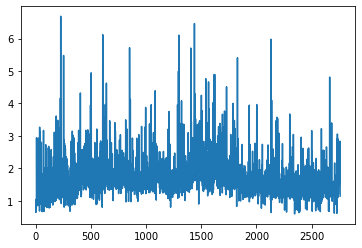

In [171]:
# import matplotlib.pyplot as plt
plt.plot(time_)

In [185]:
for i in range(20):
    print(time_[:1500][-i])

0.9195361137390137
1.6059300899505615
1.6531226634979248
2.474536657333374
2.950404167175293
2.5608267784118652
1.9936408996582031
2.6903939247131348
2.9845285415649414
2.4524383544921875
2.6373884677886963
3.1317367553710938
3.1062867641448975
1.8021793365478516
2.3158061504364014
3.465070962905884
1.8266637325286865
1.966585636138916
2.282895088195801
2.6075258255004883


In [143]:
from scipy.spatial import ConvexHull
points = t_ans[['P2','P3']].to_numpy()
hull = ConvexHull(points)
print(hull.volume)

12.917572171447485


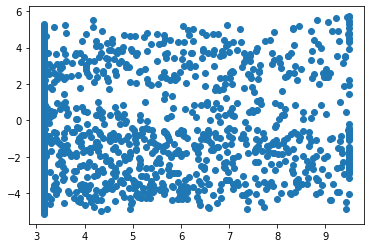

In [170]:
plt.scatter(t_ans['P4'],t_ans['Q8'])

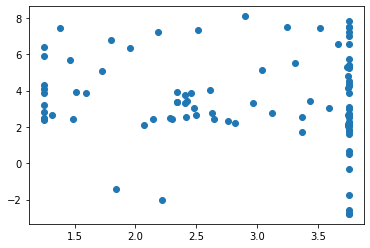

In [102]:
# temp = t_ans
import matplotlib.pyplot as plt
plt.scatter(temp['P1'],temp['Q3'])